In [2]:
%reload_ext autoreload
%autoreload 2
%cd ../
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

/home/hazzu/Code/thesis


In [2]:
import cv2
import numpy as np


def visualize_result(
    image1: cv2.typing.MatLike,
    face1: list[float],
    image2: cv2.typing.MatLike,
    face2: list[float],
    similarity: float,
    is_match: bool,
):
    drawed_image1 = image1.copy()
    drawed_image2 = image2.copy()

    x1, y1, w1, h1 = map(int, face1[:4])
    x2, y2, w2, h2 = map(int, face2[:4])

    color = (0, 0, 255)
    if is_match:
        color = (0, 255, 0)

    drawed_image1 = cv2.rectangle(drawed_image1, (x1, y1), (x1 + w1, y1 + h1), color, 2)
    drawed_image2 = cv2.rectangle(drawed_image2, (x2, y2), (x2 + w2, y2 + h2), color, 2)
    drawed_image1 = cv2.putText(
        drawed_image1,
        f"Similarity: {similarity}",
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        color,
        2,
    )

    h1, w1 = drawed_image1.shape[:2]
    h2, w2 = drawed_image2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
    vis[:h1, :w1, :3] = drawed_image1
    vis[:h2, w1 : w1 + w2, :3] = drawed_image2

    return vis

# 1. YuNet + SFace


In [ ]:
import os, csv, timeit
from tqdm import tqdm
from lib.sface import SFace
from lib.FaceDetector import YuNetDetector

yunet = YuNetDetector()
embedder = SFace(modelPath="weights/face_recognition_sface_2021dec.onnx")


def face_verify(img_path1: str, img_path2: str):
    start = timeit.default_timer()

    card_image = cv2.imread(img_path1)
    selfie_image = cv2.imread(img_path2)

    face_in_card, scale = yunet.detect_single_multiscale(card_image)
    if face_in_card is None:
        print(f"Cannot detect face in card {img_path1}")
        return None
    scaled_card_image = cv2.resize(
        card_image, (int(scale * card_image.shape[1]), int(scale * card_image.shape[0]))
    )

    face_in_selfie, scale2 = yunet.detect_single_multiscale(selfie_image)
    if face_in_selfie is None:
        print(f"Cannot detect face in selfie {img_path2}")
        return None
    scaled_selfie_image = cv2.resize(
        selfie_image,
        (int(scale2 * selfie_image.shape[1]), int(scale2 * selfie_image.shape[0])),
    )

    similarity, is_match = embedder.match(
        scaled_card_image, face_in_card, scaled_selfie_image, face_in_selfie
    )

    stop = timeit.default_timer()

    return {
        "verified": bool(is_match),
        "similarity": similarity,
        "facial_areas": {
            "img1": {
                "x": int(face_in_card[0] / scale),
                "y": int(face_in_card[1] / scale),
                "w": int(face_in_card[2] / scale),
                "h": int(face_in_card[3] / scale),
            },
            "img2": {
                "x": int(face_in_selfie[0] / scale2),
                "y": int(face_in_selfie[1] / scale2),
                "w": int(face_in_selfie[2] / scale2),
                "h": int(face_in_selfie[3] / scale2),
            },
        },
        "time": stop - start,
    }


CARDS_DIR = "datasets/cards"
SELFIES_DIR = "datasets/selfies_20241030"

cards_name = os.listdir(CARDS_DIR)
selfies_name = os.listdir(SELFIES_DIR)

yunet_name = []
yunet_similarity = []
yunet_is_match = []
yunet_time = []

for card_name in tqdm(cards_name):
    card_path = os.path.join(CARDS_DIR, card_name)
    student_id = card_name.split("_")[0]
    card_image = cv2.imread(card_path)

    # Find selfies of student
    selfies_of_student = list(filter(lambda x: student_id in x, selfies_name))
    if len(selfies_of_student) == 0:
        continue
    selfies_of_student = selfies_of_student[0]
    selfies_of_student_path = os.path.join(SELFIES_DIR, selfies_of_student)

    for selfie_name in os.listdir(selfies_of_student_path):
        selfie_path = os.path.join(selfies_of_student_path, selfie_name)
        selfie_image = cv2.imread(selfie_path)

        result = face_verify(card_path, selfie_path)
        similarity = result["similarity"]
        is_match = result["verified"]
        time = result["time"]

        face_in_card = result["facial_areas"]["img1"]
        face_in_selfie = result["facial_areas"]["img2"]
        face_in_card = [
            face_in_card["x"],
            face_in_card["y"],
            face_in_card["w"],
            face_in_card["h"],
        ]
        face_in_selfie = [
            face_in_selfie["x"],
            face_in_selfie["y"],
            face_in_selfie["w"],
            face_in_selfie["h"],
        ]

        vis = visualize_result(
            card_image,
            face_in_card,
            selfie_image,
            face_in_selfie,
            similarity,
            is_match,
        )
        os.makedirs(
            f"results/face-verification/yunet-sface/{student_id}", exist_ok=True
        )
        cv2.imwrite(
            f"results/face-verification/yunet-sface/{student_id}/{selfie_name}", vis
        )

        yunet_name.append(f"{student_id}_{selfie_name}")
        yunet_similarity.append(similarity)
        yunet_is_match.append(is_match)
        yunet_time.append(time)

fields = ["name", "similarity", "is_match", "time"]
rows = zip(yunet_name, yunet_similarity, yunet_is_match, yunet_time)
filepath = "results/face-verification/yunet-sface/result.csv"
with open(filepath, "w") as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

100%|██████████| 314/314 [00:47<00:00,  6.63it/s]


# 2. RetinaFace + ArcFace


In [ ]:
import os, csv, cv2
from tqdm import tqdm
from deepface import DeepFace

CARDS_DIR = "datasets/cards"
SELFIES_DIR = "datasets/selfies_20241030"

cards_name = os.listdir(CARDS_DIR)
selfies_name = os.listdir(SELFIES_DIR)

retinaface_name = []
retinaface_similarity = []
retinaface_is_match = []
retinaface_time = []

for card_name in tqdm(cards_name):
    card_path = os.path.join(CARDS_DIR, card_name)
    student_id = card_name.split("_")[0]
    card_image = cv2.imread(card_path)

    # Find selfies of student
    selfies_of_student = list(filter(lambda x: student_id in x, selfies_name))
    if len(selfies_of_student) == 0:
        continue
    selfies_of_student = selfies_of_student[0]
    selfies_of_student_path = os.path.join(SELFIES_DIR, selfies_of_student)

    for selfie_name in os.listdir(selfies_of_student_path):
        selfie_path = os.path.join(selfies_of_student_path, selfie_name)
        selfie_image = cv2.imread(selfie_path)

        result = DeepFace.verify(
            img1_path=card_path,
            img2_path=selfie_path,
            model_name="ArcFace",
            detector_backend="retinaface",
            silent=True,
        )

        distance = result["distance"]
        similarity = 1 - distance
        is_match = result["verified"]
        time = result["time"]

        face_in_card = result["facial_areas"]["img1"]
        face_in_selfie = result["facial_areas"]["img2"]
        face_in_card = [
            face_in_card["x"],
            face_in_card["y"],
            face_in_card["w"],
            face_in_card["h"],
        ]
        face_in_selfie = [
            face_in_selfie["x"],
            face_in_selfie["y"],
            face_in_selfie["w"],
            face_in_selfie["h"],
        ]

        vis = visualize_result(
            card_image,
            face_in_card,
            selfie_image,
            face_in_selfie,
            similarity,
            is_match,
        )
        os.makedirs(
            f"results/face-verification/retinaface-arcface/{student_id}", exist_ok=True
        )
        cv2.imwrite(
            f"results/face-verification/retinaface-arcface/{student_id}/{selfie_name}",
            vis,
        )

        retinaface_name.append(f"{student_id}_{selfie_name}")
        retinaface_similarity.append(similarity)
        retinaface_is_match.append(is_match)
        retinaface_time.append(time)

fields = ["name", "similarity", "is_match", "time"]
rows = zip(retinaface_name, retinaface_similarity, retinaface_is_match, retinaface_time)
filepath = "results/face-verification/retinaface-arcface/result.csv"
with open(filepath, "w") as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

2025-01-30 11:03:09.218589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738209789.229001   21957 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738209789.232472   21957 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 11:03:09.245973: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 314/314 [07:37<00:00,  1.46s/it]


# 3. Comparison


In [3]:
import pandas as pd

yunet_sface = pd.read_csv("results/face-verification/yunet-sface/result.csv")
retinaface_arcface = pd.read_csv(
    "results/face-verification/retinaface-arcface/result.csv"
)

yunet_sface.info()
print()
retinaface_arcface.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        99 non-null     object 
 1   similarity  99 non-null     float64
 2   is_match    99 non-null     bool   
 3   time        99 non-null     float64
dtypes: bool(1), float64(2), object(1)
memory usage: 2.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        99 non-null     object 
 1   similarity  99 non-null     float64
 2   is_match    99 non-null     bool   
 3   time        99 non-null     float64
dtypes: bool(1), float64(2), object(1)
memory usage: 2.5+ KB


## 3.1. Accuracy


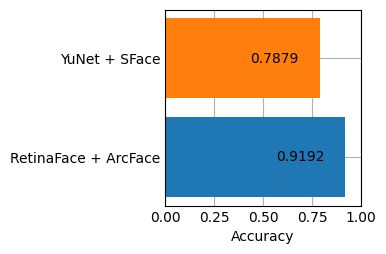

In [54]:
import matplotlib.pyplot as plt

yunet_sface_accuracy = (
    yunet_sface[yunet_sface["is_match"] == True].count()[0] / yunet_sface.count()[0]
)
retinaface_arcface_accuracy = (
    retinaface_arcface[retinaface_arcface["is_match"] == True].count()[0]
    / retinaface_arcface.count()[0]
)

fig, ax = plt.subplots()
container = ax.barh(
    ["RetinaFace + ArcFace", "YuNet + SFace"],
    [retinaface_arcface_accuracy, yunet_sface_accuracy],
    color=["#1f77b4", "#ff7f0e"],
)
ax.set_xlim(0, 1)
ax.set_xlabel("Accuracy")
ax.bar_label(container, fmt="%.4f", padding=-50)

plt.savefig("results/face-verification/accuracy.png", bbox_inches="tight")

## 3.2. Similarity


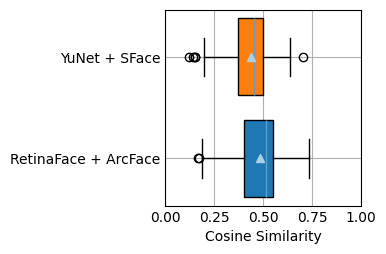

In [115]:
import matplotlib.pyplot as plt

yunet_sface_similarity = yunet_sface["similarity"]
retinaface_arcface_similarity = retinaface_arcface["similarity"]

fig, ax = plt.subplots()
bplot = ax.boxplot(
    [retinaface_arcface_similarity, yunet_sface_similarity],
    positions=[1, 3],
    widths=1.5,
    showfliers=True,
    patch_artist=True,
    showmeans=True,
    tick_labels=["RetinaFace + ArcFace", "YuNet + SFace"],
    orientation="horizontal",
)

bplot["boxes"][0].set_facecolor("#1f77b4")
bplot["boxes"][1].set_facecolor("#ff7f0e")
ax.set_xlim(0, 1)
ax.set_xlabel("Cosine Similarity")

plt.savefig("results/face-verification/similarity.png", bbox_inches="tight")

## 3.3. Speed


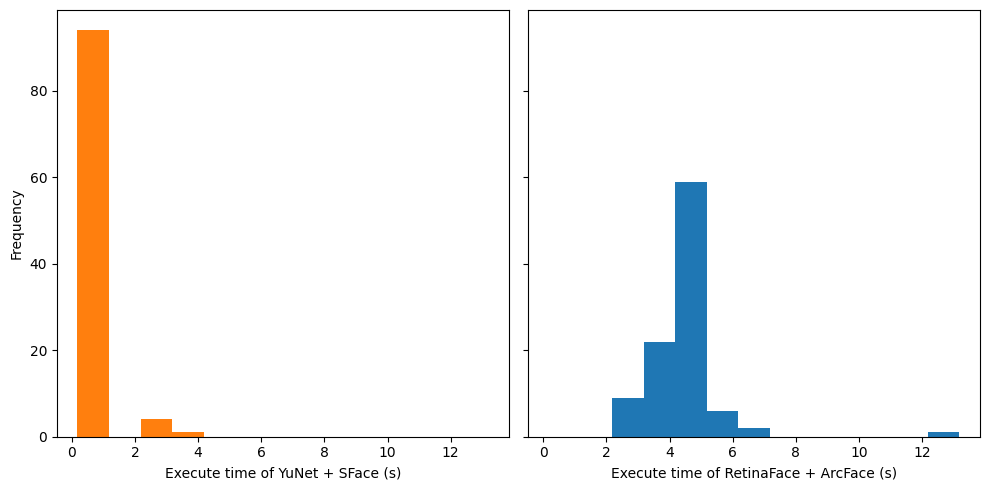

In [11]:
import numpy as np
import matplotlib.pyplot as plt

yunet_sface_time = yunet_sface["time"]
retinaface_arcface_time = retinaface_arcface["time"]

bin_width = 1
bins = np.arange(
    np.min([yunet_sface_time, yunet_sface_time]),
    np.max([retinaface_arcface_time, retinaface_arcface_time]) + bin_width,
    bin_width,
)

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.set_size_inches(10, 5)
axs[0].hist(
    yunet_sface_time,
    bins=bins,
    label="YuNet + SFace",
    color="#ff7f0e",
)
axs[1].hist(
    retinaface_arcface_time,
    bins=bins,
    label="RetinaFace + ArcFace",
    color="#1f77b4",
)
axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Execute time of YuNet + SFace (s)")
axs[1].set_xlabel("Execute time of RetinaFace + ArcFace (s)")

plt.savefig("results/face-verification/execute-time.png", bbox_inches="tight")

In [17]:
print(f"Mean execute time of YuNet + SFace: {yunet_sface_time.mean():.4f}s")
print(
    f"Mean execute time of RetinaFace + ArcFace: {retinaface_arcface_time.mean():.4f}s"
)

Mean execute time of YuNet + SFace: 0.3716s
Mean execute time of RetinaFace + ArcFace: 4.4805s


In [10]:
for i in range(yunet_sface["name"].size):
    if yunet_sface["is_match"][i] != retinaface_arcface["is_match"][i]:
        print(
            yunet_sface["name"][i],
            yunet_sface["is_match"][i],
            retinaface_arcface["is_match"][i],
        )
    elif yunet_sface["is_match"][i] == False:
        print(
            yunet_sface["name"][i],
            yunet_sface["similarity"][i],
            retinaface_arcface["similarity"][i],
        )

24T1020247_vlcsnap-00030.png False True
24T1020247_vlcsnap-00032.png False True
24T1020052_vlcsnap-00005.png False True
24T1020052_vlcsnap-00006.png 0.2652612092262245 0.262233059
24T1020052_vlcsnap-00004.png False True
24T1020509_vlcsnap-00091.png False True
24T1020509_vlcsnap-00092.png False True
24T1020271_vlcsnap-00032.png True False
24T1020453_vlcsnap-00060.png False True
24T1020160_vlcsnap-00013.png False True
24T1020160_vlcsnap-00014.png False True
24T1020520_vlcsnap-00008.png True False
24T1020328_vlcsnap-00043.png 0.3252818952614689 0.231573035
24T1020328_vlcsnap-00042.png False True
24T1020328_vlcsnap-00041.png False True
24T1020275_vlcsnap-00035.png 0.1219828110856724 0.169203813
24T1020275_vlcsnap-00034.png False True
24T1020275_vlcsnap-00036.png 0.2035929127814597 0.302167115
24T1020275_vlcsnap-00037.png False True
24T1020513_vlcsnap-00096.png True False
24T1020239_vlcsnap-00029.png False True
24T1020118_vlcsnap-00009.png False True
24T1020585_vlcsnap-00020.png False True
